In [3]:
import sys
sys.path.append("..")
from allthethings import PyNetwork, PyPipe_ps
from allthethings import PyBC_opt_dh
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
from scipy import optimize
from writeit import rewritePipes

Populating the interactive namespace from numpy and matplotlib


In [4]:
def idx_t(i,j,n,N):
    return (2*(N+2)*n+(N+2)*i+j)

In [78]:
oldinp = "../indata/DFDpleasework2.inp"
fn = "../indata/DFD_crap"
Mi = 10
Nt = 1
case =0
Nstar = 0
Np  =7
Nn = 8
L = 10
T = 40
a = 100
D = .1
Ls = [L]*Np
Ns = [int(l) for l in Ls]
#jt = [1,3,1,3,1,3,1,1]#for DFDpleasework.inp
jt = [1,2,2,2,2,2,2,1]#for DFDpleasework2.inp
bt = [0,1,1,1,1,1,1,1]
bv = [0,1,1,1,1,1,1,1]
r =  [0,1,1,1,1,1,1,-1]
h0s = [0]*Np
q0s = [0]*Np
dx = [L/Ns[0]]
Mrs = [0.001]*Np
if(case==0):
    elevs = [10,9,8,7, 6,7.5,9,10]
elif(case==1):
    elevs =[10,11,9,7,6,8,11,10]
elif(case==2):
    elevs =[10,9,8,8,6,7,7,10]
elif(case==3):
    elevs =[10,8,9,8,6,7,8,10]
elif(case==4):
    elevs =[10,8,9,6,6,8,9,10]
#elevs =[10,11,10,10,6,10,10,10]
#elevs =[10, 9,8,5,6,4,4,3]
#elevs = [10,9,8,7,6,5,4,3]
#elevs = [10,9.5,9,8.5,8,7,6,3]
#elevs = [10, 11, 9, 8, 5, 6, 4,3]
Ds = [D]*Np
M = max(int(T*a/(max(dx)*.8))*5,1)
Ls = [L]*Np
(fi, fc) = rewritePipes(fn,oldinp, Ns, Ls, Mrs, Ds, jt, bt, bv, r, h0s, q0s, T, M, a, elevs)
dt = T/float(M)
Hs =np.ndarray((Np,M/Mi*Nt))
Us = np.ndarray((Np,M/Mi*Nt))

new files are ../indata/DFD_crap.inp and ../indata/DFD_crap.config


In [79]:
n1 = PyNetwork(fi,fc,1)
Q00 = 0.0087*np.ones(M+1)
j = 0
p0 = PyPipe_ps(n1.Ns[j],n1.Ds[j], n1.Ls[j],M,a)
Ain = p0.AofH(10,False)
Q00 = Ain*np.ones(M+1)
n1.setbVal(0,Q00)
A0 = Ain*np.ones(Ns[0])
Q0 = np.zeros(Ns[0])
n1.setIC(0,A0,Q0)
#n1.showCurrentData()

0
[0.07930180963787685, 0.5581469275624045]


/Users/lieba/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: RuntimeWarning: invalid value encountered in double_scalars
/Users/lieba/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: RuntimeWarning: divide by zero encountered in double_scalars


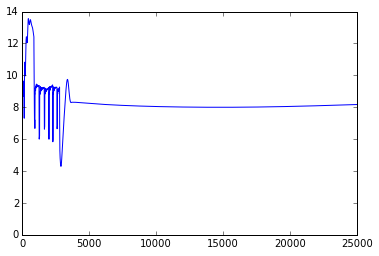

In [80]:
Vs = [n1.getTotalVolume()]
for m in range(Nt):
    n1.runForwardProblem(dt)
    for j in range(Np):
        N = n1.Ns[j]
        p0 = PyPipe_ps(N,n1.Ds[j], n1.Ls[j],M,a)
        qh = n1.qhist(j)
        Htemp = [p0.pbar(qh[idx_t(0,Nstar,n,n1.Ns[j])],False) for n in range(1,M+1,Mi)]
        Utemp = [qh[idx_t(1,Nstar,n,n1.Ns[j])]/qh[idx_t(0,Nstar,n,n1.Ns[j])] for n in range(1,M+1,Mi)]
        Us[j,m*(M/Mi):(M/Mi)*(m+1)] = Utemp
        Hs[j,m*(M/Mi):(M/Mi)*(m+1)] = Htemp
    Vs.append(n1.getTotalVolume()) 
    print m
    print Vs
    n1.reset()
dH = [n1.getAveGradH(i) for i in range(M+1)]
plot(dH)

(0, 11)

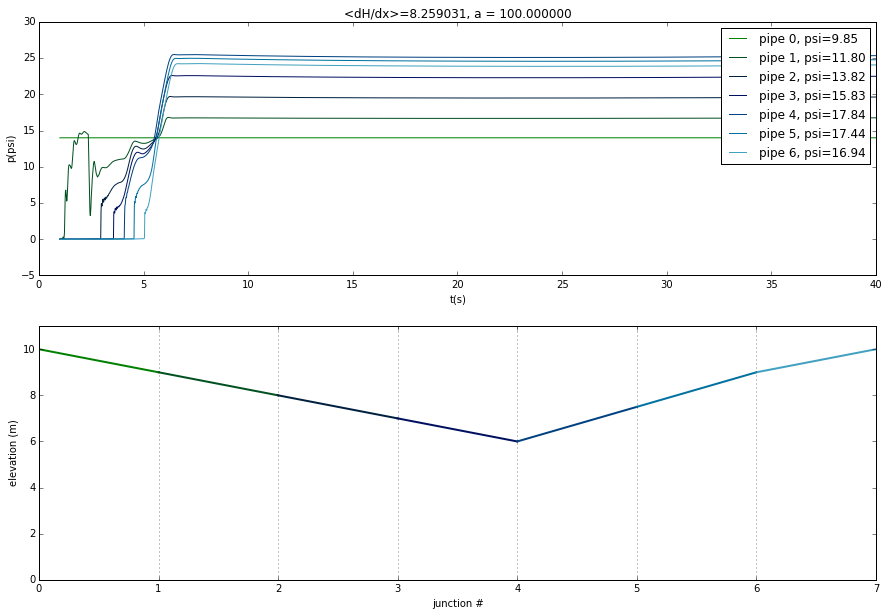

In [81]:
m2psi = 1.42
from matplotlib import cm
import matplotlib.colors as colors  
cNorm  = colors.Normalize(vmin=0, vmax=Np+1)
fig,ax = plt.subplots(nrows=2, figsize=(15,10))
scalarMap = cm.ScalarMappable(norm=cNorm, cmap=cm.get_cmap('ocean'))
Ttot= T*Nt
t=linspace(1,Ttot,len(Hs[0]))
for j in range(0,Np):
    ax[0].plot(t,Hs[j]*m2psi, color = scalarMap.to_rgba(j), label = "pipe %d, psi=%.2f"%(j,Hs[j][-1]))
legend(ncol=3, loc = 'lower right')
ylabel('p (psi)')
xlabel('t (s)')
ax[0].legend(loc ='upper right')
ax[0].set_title('<dH/dx>=%f, a = %f'%(mean(dH),a))
#ax[0].set_ylim(0,35)
ax[0].set_ylabel('p(psi)')
ax[0].set_xlabel('t(s)')
Ltot = 0
E = elevs[0]
xs = []
#fig,ax = plt.subplots(figsize=(15,5))
for k in range(Nn-1):
    L = n1.Ls[k]
    x = linspace(0,L)
    cval = scalarMap.to_rgba(k)
    ax[1].plot(x+Ltot,x*(elevs[k+1]-elevs[k])/L+E,color = cval, lw = 2)
    xs.append(Ltot)
    Ltot+=L
    E = elevs[k+1]
xs.append(Ltot)
ax[1].set_xticks(xs);
ax[1].xaxis.grid(True)
ax[1].set_xticklabels(arange(0,Nn+1));
ylabel('elevation (m)')
xlabel('junction #')
ax[1].set_ylim(0,11)
#ax[0].set_xlim(9,10)
#savefig('/Users/lieba/Desktop/elevation_profilecase%d.png'%case)

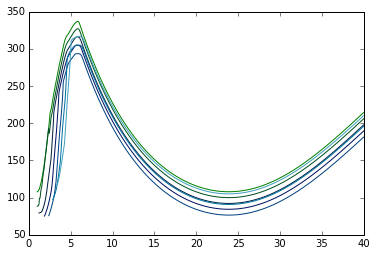

In [82]:
t=linspace(1,Ttot,len(Hs[0]))
for j in range(0,Np):
    plot(t,[(u**2)/2+9.8*elevs[j] for u in Us[j]]+Hs[j], color = scalarMap.to_rgba(j), label = "pipe %d"%(j))
#legend(ncol=3, loc = 'lower right')

In [86]:
B = [(Us[j][-1]**2)/2+9.8*elevs[j]+Hs[j][-1] for j in range(Np)]
print B

[214.32795335060834, 205.91719902249156, 197.7150756081991, 189.50891418541312, 181.29872455327751, 195.86412521028643, 210.16762673005385]


In [84]:
m32gal=264.172052
print "a = %f m/s" %a
print "inflow volume = %.2f gallons"%((Vs[-1]-Vs[0])*m32gal)

a = 100.000000 m/s
inflow volume = 126.50 gallons


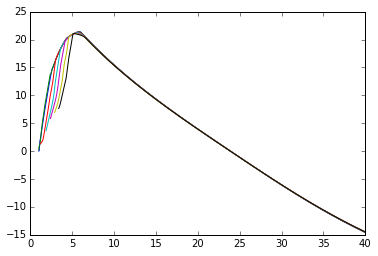

In [87]:
for j in range(Np):
    plot(t,Us[j])

In [105]:
g = 9.8
D = n1.Ds[0]
Af = np.pi*D**2/4
Rh = Af/(np.pi*D)
S = (Us[3][-1]*Mrs[0])**2/pow(Rh,4./3.)
print S*L*g

2.81740827681


In [107]:
print diff([Hs[j][-1] for j in range(Np)])
print ([Hs[j][-1] for j in range(Np)])

[ 1.94096922  2.02101559  2.01407015  2.00716429 -0.39727417 -0.50411852]
[9.8543926823434642, 11.795361903699517, 13.816377490611989, 15.830447639621175, 17.837611931247874, 17.440337758679842, 16.93621924234256]


In [24]:
print [e*3.048 for e in elevs]

[30.48, 27.432000000000002, 24.384, 24.384, 18.288, 21.336, 21.336, 30.48]


In [106]:
print Mi

10


(7, 300)
[ 9.88341052  9.71529195  8.30117223  5.84469797  3.59112352  2.21524789
  1.86367425  2.42553255  3.60699832  5.01697496  6.29036024  7.16598959
  7.5117343   7.3435416   6.78851541  6.02873776  5.26111393  4.66011405
  4.33722242  4.32306157  4.57341258  4.98912876  5.45001264  5.84493162
  6.10104699  6.23783408  6.3334228   6.41564951  6.45358825  6.39967385
  6.22174307  5.91905413  5.52506356  5.10749001  4.75648296  4.55699282
  4.56090737  4.77270715  5.15151806  5.62492782  6.10789575  6.5211236
  6.80516016  6.92827745  6.88753635  6.70285811  6.40746266  6.04350721
  5.66201872  5.31978352  5.07064204  4.95409295  4.98610389  5.15568138
  5.42844062  5.75560383  6.0846752   6.36867241  6.57252227  6.67645374
  6.6768195   6.58490269  6.42411922  6.22585478  6.02410878  5.84971663
  5.72581227  5.66549512  5.67148075  5.73716426  5.84862413  5.98719704
  6.13228418  6.26415683  6.3665961   6.42903029  6.44775274  6.42597827
  6.37276926  6.30109401  6.22541475  6.159